## Load Mediapipe library

In [1]:
# https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/latest/hand_landmarker.task
import mediapipe as mp
import numpy as np
from mediapipe.framework.formats import landmark_pb2
import cv2

In [2]:
BaseOptions = mp.tasks.BaseOptions
HandLandmarker = mp.tasks.vision.HandLandmarker
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

model_path = 'hand_landmarker.task'

# options for landmarker in image mode:
options = mp.tasks.vision.HandLandmarkerOptions(
    base_options=mp.tasks.BaseOptions(model_asset_path=model_path),
    running_mode=mp.tasks.vision.RunningMode.IMAGE,
    min_hand_detection_confidence = 0.2,
    min_hand_presence_confidence = 0.2,
    min_tracking_confidence = 0.2,
    # num_hands=2
)

def close(landmarker):
  landmarker.close()

In [3]:
# Only for livestream results
def get_result(result: mp.tasks.vision.HandLandmarkerResult, output_image: mp.Image, timestamp_ms: int):
    return result
    # print(f'hand landmarker result: {result}') 



In [4]:
def draw_landmarks_on_image(rgb_image, detection_result: mp.tasks.vision.HandLandmarkerResult):
    """Courtesy of https://github.com/googlesamples/mediapipe/blob/main/examples/hand_landmarker/python/hand_landmarker.ipynb"""
    global first
    try:
        if detection_result.hand_landmarks == []:
            return rgb_image
        else:
            hand_landmarks_list = detection_result.hand_landmarks
            annotated_image = np.copy(rgb_image)
            
            # Loop through the detected hands to visualize.
            for idx in range(len(hand_landmarks_list)):
                print(hand_landmarks_list[idx])
                hand_landmarks = hand_landmarks_list[idx]
                # Draw the hand landmarks.
                hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
                hand_landmarks_proto.landmark.extend([
                    landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks])
                mp.solutions.drawing_utils.draw_landmarks(
                    annotated_image,
                    hand_landmarks_proto,
                    mp.solutions.hands.HAND_CONNECTIONS,
                    mp.solutions.drawing_styles.get_default_hand_landmarks_style(),
                    mp.solutions.drawing_styles.get_default_hand_connections_style())
                
            return annotated_image
    except Exception as e:
        print(e, 'exception')
        return rgb_image

In [5]:
def detect(image, clazz, landmarker):
    return (landmarker.detect(image=image), clazz)

## Test mediapipe on image

In [7]:
# load the landmarker
landmarker = mp.tasks.vision.HandLandmarker.create_from_options(options)

# load image
image = mp.Image.create_from_file('./data/American Sign Language Letters.v1-v1.tensorflow/train/M18_jpg.rf.129826d37d00c7e46376752d8649edaa.jpg')

# detect result to draw detected keypoints on frame
detection_result = detect(image, 'A', landmarker)
image_with_landmarks = draw_landmarks_on_image(image.numpy_view(), detection_result[0])

# show frame with keypoints drawn
cv2.imshow('Image', image_with_landmarks)

# stop!
cv2.waitKey(0)
        
close(landmarker)
cv2.destroyAllWindows()

I0000 00:00:1762805004.397069 23253477 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M2
W0000 00:00:1762805004.413693 23254709 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762805004.421441 23254709 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762805004.528260 23254712 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


[NormalizedLandmark(x=0.4512444734573364, y=0.6170030236244202, z=-9.343098383851611e-08, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.48954522609710693, y=0.5841641426086426, z=-0.02537645399570465, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.4955238997936249, y=0.5283651947975159, z=-0.044034961611032486, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.44175049662590027, y=0.500369668006897, z=-0.06216815486550331, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.3925633132457733, y=0.48377835750579834, z=-0.07727379351854324, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.4785412847995758, y=0.46633273363113403, z=-0.026574909687042236, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.4938644468784332, y=0.424955278635025, z=-0.06438133120536804, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5115581154823303, y=0.4621637463569641, z=-0.0878673866391182, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5188916325569153, y=0.50019

In [9]:
def get_keypoints(landmarker, base_path, file_name, clazz):
    image = mp.Image.create_from_file(base_path + file_name)
    return detect(image, clazz, landmarker)

## Normalizing data

In [10]:
def create_coord_list(detected_landmarks, mirror):
  coord_list = []
  for i in detected_landmarks:
    if mirror: 
        coord_list.append([-i.x, i.y, i.z])
    else:
        coord_list.append([i.x, i.y, i.z])
  return coord_list
    
def orthonormal_basis_from_triangle(p1, p2, p3):
    """Return orthonormal triad (e1,e2,e3): e1 along (p2-p1), e2 in the plane, e3 = normal."""
    u = p2 - p1
    v = p3 - p1
    n = np.cross(u, v)
    if np.linalg.norm(n) < 1e-12:
        raise ValueError("Anchor points are collinear; cannot define a plane.")
    e1 = u / np.linalg.norm(u)
    v_perp = v - np.dot(v, e1) * e1
    e2 = v_perp / np.linalg.norm(v_perp)
    e3 = np.cross(e1, e2)  # already unit
    return e1, e2, e3

def solve_affine2d(src_xy, dst_xy):
    """Solve 2D affine mapping (x,y)->(X,Y) from 3 point pairs. Returns 2x2 M and 2-dim t."""
    A, b = [], []
    for (x, y), (X, Y) in zip(src_xy, dst_xy):
        A.append([x, y, 1, 0, 0, 0])
        A.append([0, 0, 0, x, y, 1])
        b += [X, Y]
    A = np.asarray(A, float)
    b = np.asarray(b, float)
    m11, m12, tx, m21, m22, ty = np.linalg.solve(A, b)
    M = np.array([[m11, m12],
                  [m21, m22]], float)
    t = np.array([tx, ty], float)
    return M, t

def tilt_from_z_original(P, idx0=0, idx1=17, degrees=False):
    """
    Angle between the original vector P[idx1]-P[idx0] and the global z-axis.
    Returns angle in radians
    """
    v = np.asarray(P[idx1]) - np.asarray(P[idx0])
    n = np.linalg.norm(v)
    if n < 1e-12:
        return np.nan  # or raise ValueError("Zero-length vector")
    v_unit = v / n
    cos_theta = np.clip(v_unit[2], -1.0, 1.0)   # dot(v̂, ẑ) = z-component
    theta = np.arccos(cos_theta)                # 0 = vertical, pi/2 = horizontal
    return theta

def normalize_landmarks(points, anchor_idx=(0,17,5), lambda_normal=1.0):
    """
    Build a 3D affine transform (A,t) so that:
      P[i1] -> (0,0,0), P[i2] -> (0,1,0), P[i3] -> (1,1,0),
    and the plane normal maps to the Z axis with scale lambda_normal.
    Returns transformed points (N,3) and (A,t).
    """
    P = np.asarray(points, float)
    i1, i2, i3 = anchor_idx
    p1, p2, p3 = P[i1], P[i2], P[i3]

    # Local orthonormal basis B = [e1 e2 e3]
    e1, e2, e3 = orthonormal_basis_from_triangle(p1, p2, p3)
    B = np.column_stack([e1, e2, e3])          # world <- local
    BT = B.T                                    # local <- world

    # Local coordinates of anchors (q = BT * (p - p1))
    q1 = BT @ (p1 - p1)                         # ~ (0,0,0)
    q2 = BT @ (p2 - p1)                         # (x2, y2, 0)
    q3 = BT @ (p3 - p1)                         # (x3, y3, 0)

    src_xy = np.vstack([q1[:2], q2[:2], q3[:2]])
    dst_xy = np.array([[0.,0.],[0.,1.],[1.,1.]], float)

    # Exact 2D affine that hits the three targets in XY
    M2, t2 = solve_affine2d(src_xy, dst_xy)

    # Compose full 3x3 local linear map: XY via M2, Z via lambda_normal
    L_local = np.array([[M2[0,0], M2[0,1], 0.0],
                        [M2[1,0], M2[1,1], 0.0],
                        [0.0,      0.0,    lambda_normal]], float)

    # Because q1 = (0,0,0) maps to (0,0,0), t2 should be ~0; keep it for completeness
    t_local = np.array([t2[0], t2[1], 0.0], float)

    # Convert to a single world-space affine: P' = A @ P + t
    # q = BT @ (P - p1);  q' = L_local @ q + t_local;  P' = q'  (targets are in world axes)
    A = L_local @ BT
    t = -L_local @ (BT @ p1) + t_local

    # Apply to all points
    normalized_points = (A @ P.T).T + t

    return normalized_points, tilt_from_z_original(points)

In [11]:
def store_result(result, clazz, normalize = False, include_tilt = False, mirror = False):
    d = {}
    if normalize:
        coords = create_coord_list(result.hand_landmarks[0], mirror)
        norm_coords, tilt = normalize_landmarks(coords)
        for k in range(len(coords)):
            d[str(k)+'_x'] = norm_coords[k][0]
            d[str(k)+'_y'] = norm_coords[k][1]
            d[str(k)+'_z'] = norm_coords[k][2]
        if include_tilt:
            d['tilt'] = tilt
    else:
        for k,v in enumerate(result.hand_landmarks[0]):
            d[str(k)+'_x'] = v.x
            d[str(k)+'_y'] = v.y
            d[str(k)+'_z'] = v.z
        
    d['clazz'] = clazz
    # print(d)
    return d
    
    # store result values in dict and add to list

In [12]:
# convert list of dicts to pd.df
def get_data_frame(result_list):
    return pd.DataFrame(result_list)

## Load data

In [14]:
#!pip install pandas==2.1.4 moet numpy <2 gebruiken voor mediapipe!
import pandas as pd

# create the landmarker
landmarker = mp.tasks.vision.HandLandmarker.create_from_options(options)

data_path = './data/American Sign Language Letters.v1-v1.tensorflow/'

train_data = pd.read_csv(data_path + 'train/_annotations.csv')
train_data.head()

valid_data = pd.read_csv(data_path + 'valid/_annotations.csv')
valid_data.head()

test_data = pd.read_csv(data_path + 'test/_annotations.csv')
test_data.head()

train_data[:1]
counter = 0

def store_data(data, folder, normalize=False, include_tilt=False, mirrorleft=False):
    result_list = []
    # loop through images in csv and get results
    for i in range(len(data)):
        values = data[i:i+1][['filename','class']].values[0]
        file_name, clazz = values[0], values[1]
        result = get_keypoints(landmarker, data_path + folder, file_name, clazz)
        if len(result[0].hand_landmarks) > 0:
            handedness = result[0].handedness[0][0].display_name
            mirror = False
            if mirrorleft and handedness == 'Left':
                mirror = True
            result_list.append(store_result(result[0], clazz, normalize, include_tilt, mirror))
    return result_list


I0000 00:00:1762805191.899764 23253477 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M2
W0000 00:00:1762805191.915614 23258448 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762805191.926190 23258448 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [15]:
# training features and target
X_features = ['0_x','0_y','0_z','1_x','1_y','1_z','2_x','2_y','2_z'
                    ,'3_x','3_y','3_z','4_x','4_y','4_z','5_x','5_y','5_z'
                    ,'6_x','6_y','6_z','7_x','7_y','7_z','8_x','8_y','8_z'
                    ,'9_x','9_y','9_z','10_x','10_y','10_z','11_x','11_y','11_z'
                    ,'12_x','12_y','12_z','13_x','13_y','13_z','14_x','14_y','14_z'
                    ,'15_x','15_y','15_z','16_x','16_y','16_z','17_x','17_y','17_z'
                    ,'18_x','18_y','18_z','19_x','19_y','19_z','20_x','20_y','20_z'
]

# features including tilt
X_features_tilt = X_features.copy()
X_features_tilt.append('tilt')

y_target = 'clazz'

In [16]:
# Load results into DataFrame
df_train = get_data_frame(store_data(train_data, 'train/'))
df_train.head()

df_valid = get_data_frame(store_data(valid_data, 'valid/'))
df_valid.head()

df_test = get_data_frame(store_data(test_data, 'test/'))
df_test.head()

# split into data and targets
df_training_x = df_train[X_features]
df_valid_x = df_valid[X_features]
df_test_x = df_test[X_features]

df_training_y = df_train[y_target]
df_valid_y = df_valid[y_target]
df_test_y = df_test[y_target]

# print information for DataFrame
print(df_training_y.info())
print(df_training_y.values)

<class 'pandas.core.series.Series'>
RangeIndex: 1298 entries, 0 to 1297
Series name: clazz
Non-Null Count  Dtype 
--------------  ----- 
1298 non-null   object
dtypes: object(1)
memory usage: 10.3+ KB
None
['U' 'K' 'W' ... 'A' 'W' 'S']


In [17]:
# Load normalized results into DataFrame
df_train_normalized = get_data_frame(store_data(train_data, 'train/', True))
df_train_normalized.head()

df_valid_normalized = get_data_frame(store_data(valid_data, 'valid/', True))
df_valid_normalized.head()

df_test_normalized = get_data_frame(store_data(test_data, 'test/', True))
df_test_normalized.head()

# prepare normalized data for training
df_training_normalized_x = df_train_normalized[X_features]
df_valid_normalized_x = df_valid_normalized[X_features]
df_test_normalized_x = df_test_normalized[X_features]

df_training_normalized_y = df_train_normalized[y_target]
df_valid_normalized_y = df_valid_normalized[y_target]
df_test_normalized_y = df_test_normalized[y_target]


In [18]:
# Load normalized results including tilt into DataFrame
df_train_normalized_tilt = get_data_frame(store_data(train_data, 'train/', True, True))
df_train_normalized_tilt.head()

df_valid_normalized_tilt = get_data_frame(store_data(valid_data, 'valid/', True, True))
df_valid_normalized_tilt.head()

df_test_normalized_tilt = get_data_frame(store_data(test_data, 'test/', True, True))
df_test_normalized_tilt.head()

# prepare normalized data for training
df_training_normalized_tilt_x = df_train_normalized_tilt[X_features_tilt]
df_valid_normalized_tilt_x = df_valid_normalized_tilt[X_features_tilt]
df_test_normalized_tilt_x = df_test_normalized_tilt[X_features_tilt]

df_training_normalized_tilt_y = df_train_normalized_tilt[y_target]
df_valid_normalized_tilt_y = df_valid_normalized_tilt[y_target]
df_test_normalized_tilt_y = df_test_normalized_tilt[y_target]


In [30]:
# Load normalized results including tilt into DataFrame
df_train_normalized_tilt_mirror = get_data_frame(store_data(train_data, 'train/', True, True, True))
df_train_normalized_tilt_mirror.head()

df_valid_normalized_tilt_mirror = get_data_frame(store_data(valid_data, 'valid/', True, True, True))
df_valid_normalized_tilt_mirror.head()

df_test_normalized_tilt_mirror = get_data_frame(store_data(test_data, 'test/', True, True, True))
df_test_normalized_tilt_mirror.head()

# prepare normalized data for training
df_training_normalized_tilt_mirror_x = df_train_normalized_tilt_mirror[X_features_tilt]
df_valid_normalized_tilt_mirror_x = df_valid_normalized_tilt_mirror[X_features_tilt]
df_test_normalized_tilt_mirror_x = df_test_normalized_tilt_mirror[X_features_tilt]

df_training_normalized_tilt_mirror_y = df_train_normalized_tilt_mirror[y_target]
df_valid_normalized_tilt_mirror_y = df_valid_normalized_tilt_mirror[y_target]
df_test_normalized_tilt_mirror_y = df_test_normalized_tilt_mirror[y_target]


## T-SNE for clustering data (raw data / normalized data / normalized data including tilt)

In [31]:
# TSNE
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches

colors = {
    'A': 'red',
    'B': 'orange',
    'C': 'yellow',
    'D': 'green',
    'E': 'blue',
    'F': 'purple',
    'G': 'darkgoldenrod',
    'H': 'gray',
    'I': 'black',
    'J': 'lightblue',
    'K': 'lightcoral',
    'L': 'lightgreen',
    'M': 'limegreen',
    'N': 'darkgreen',
    'O': 'darkred',
    'P': 'darkblue',
    'Q': 'lightgray',
    'R': 'darkslateblue',
    'S': 'lightcyan',
    'T': 'wheat',
    'U': 'pink',
    'V': 'fuchsia',
    'W': 'indigo',
    'X': 'plum',
    'Y': 'crimson',
    'Z': 'lightseagreen',
}

legend = [
    mpatches.Patch(color=colors['A'], label='A'),
    mpatches.Patch(color=colors['B'], label='B'),
    mpatches.Patch(color=colors['C'], label='C'),
    mpatches.Patch(color=colors['D'], label='D'),
    mpatches.Patch(color=colors['E'], label='E'),
    mpatches.Patch(color=colors['F'], label='F'),
    mpatches.Patch(color=colors['G'], label='G'),
    mpatches.Patch(color=colors['H'], label='H'),
    mpatches.Patch(color=colors['I'], label='I'),
    mpatches.Patch(color=colors['J'], label='J'),
    mpatches.Patch(color=colors['K'], label='K'),
    mpatches.Patch(color=colors['L'], label='L'),
    mpatches.Patch(color=colors['M'], label='M'),
    mpatches.Patch(color=colors['N'], label='N'),
    mpatches.Patch(color=colors['O'], label='O'),
    mpatches.Patch(color=colors['P'], label='P'),
    mpatches.Patch(color=colors['Q'], label='Q'),
    mpatches.Patch(color=colors['R'], label='R'),
    mpatches.Patch(color=colors['S'], label='S'),
    mpatches.Patch(color=colors['T'], label='T'),
    mpatches.Patch(color=colors['U'], label='U'),
    mpatches.Patch(color=colors['V'], label='V'),
    mpatches.Patch(color=colors['W'], label='W'),
    mpatches.Patch(color=colors['X'], label='X'),
    mpatches.Patch(color=colors['Y'], label='Y'),
    mpatches.Patch(color=colors['Z'], label='Z')
]

def compute_tsne(X, perplexity):
    df_tsne_x = X.copy(deep=True)
    tsne_model = TSNE(random_state=42, verbose=True, n_jobs=1, perplexity=perplexity, init='pca')
    df_tsne_x[['x', 'y']] = tsne_model.fit_transform(X=df_tsne_x.apply(func=pd.Series))
    return tsne_model, df_tsne_x
    
def plot_tsne(X, y, perplexity):
    # get model and x/y values
    model, df_tsne_x = compute_tsne(X, perplexity)
    
    # merge with target values for displaying labels
    df_tsne_xy = df_tsne_x.join(y)
    color_list = [colors[c] for c in df_tsne_xy['clazz']]

    # plot
    ax = df_tsne_xy.plot.scatter(x='x', y='y',c=color_list, grid=True, figsize=(12, 12))
    ax.legend(handles=legend,
          loc='upper left')
    for i, clazz in enumerate(df_tsne_xy['clazz']):
        ax.annotate(clazz, (df_tsne_xy.iloc[i]['x'], df_tsne_xy.iloc[i]['y']), fontsize=5)
    plt.show()

In [32]:
import matplotlib.pyplot as plt

# perplexity is the effective number of neighbours. from our training set the average number of neighbours is:
avg_neighbours = len(df_training_x)/26

# the minimum number of neighbours
min_neighbours = min(df_training_x.join(df_training_y).groupby('clazz')['clazz'].value_counts())

# perplexities
perplexities = np.linspace(min_neighbours, avg_neighbours, 3)

[t-SNE] Computing 100 nearest neighbors...
[t-SNE] Indexed 1298 samples in 0.001s...
[t-SNE] Computed neighbors for 1298 samples in 0.044s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1298
[t-SNE] Computed conditional probabilities for sample 1298 / 1298
[t-SNE] Mean sigma: 0.341407
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.684357
[t-SNE] KL divergence after 1000 iterations: 0.924820


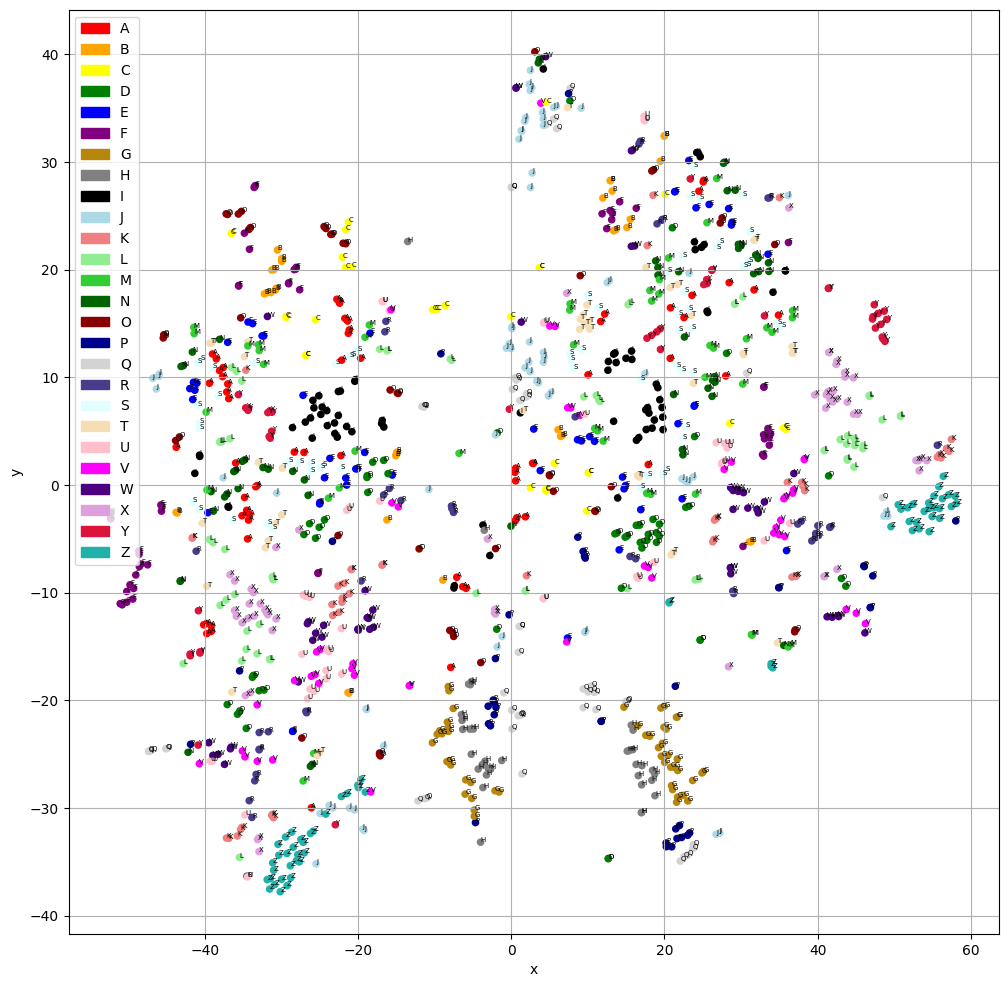

[t-SNE] Computing 125 nearest neighbors...
[t-SNE] Indexed 1298 samples in 0.000s...
[t-SNE] Computed neighbors for 1298 samples in 0.022s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1298
[t-SNE] Computed conditional probabilities for sample 1298 / 1298
[t-SNE] Mean sigma: 0.356368
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.713943
[t-SNE] KL divergence after 1000 iterations: 0.940829


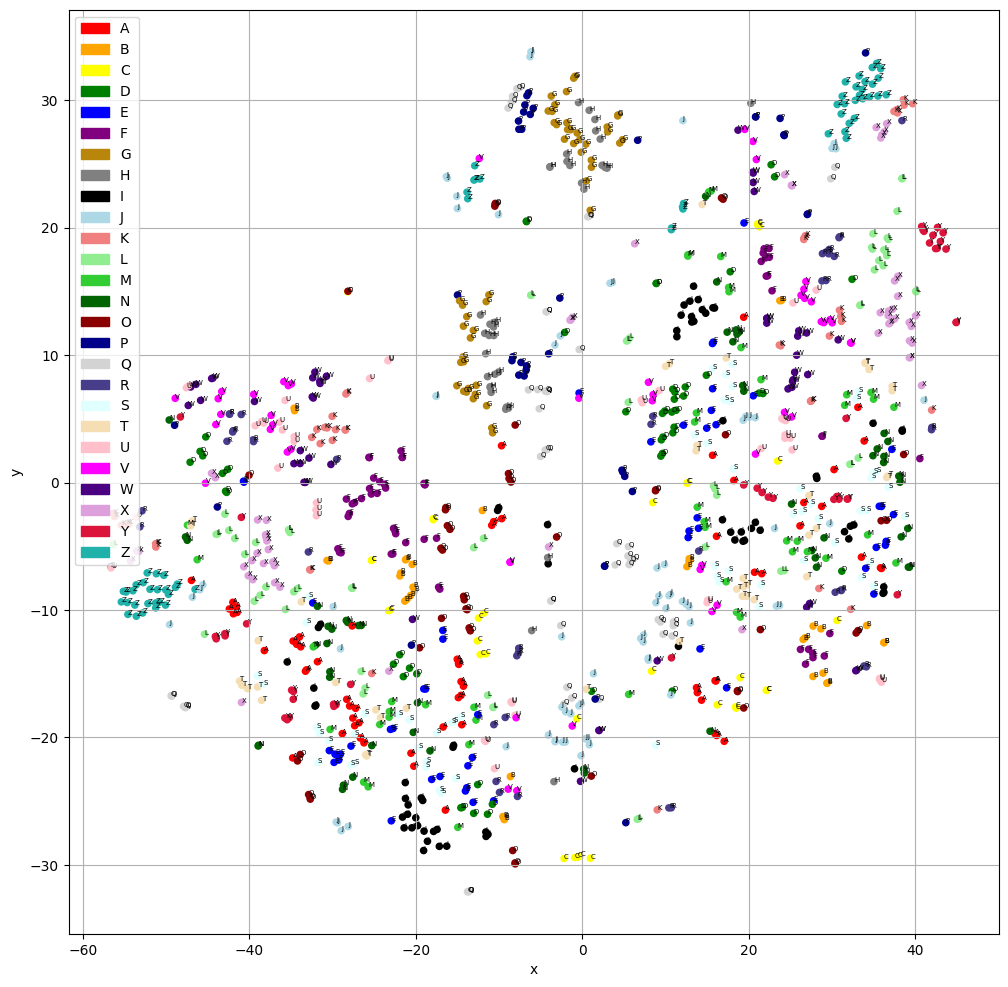

[t-SNE] Computing 150 nearest neighbors...
[t-SNE] Indexed 1298 samples in 0.000s...
[t-SNE] Computed neighbors for 1298 samples in 0.022s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1298
[t-SNE] Computed conditional probabilities for sample 1298 / 1298
[t-SNE] Mean sigma: 0.368940
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.109184
[t-SNE] KL divergence after 1000 iterations: 0.942701


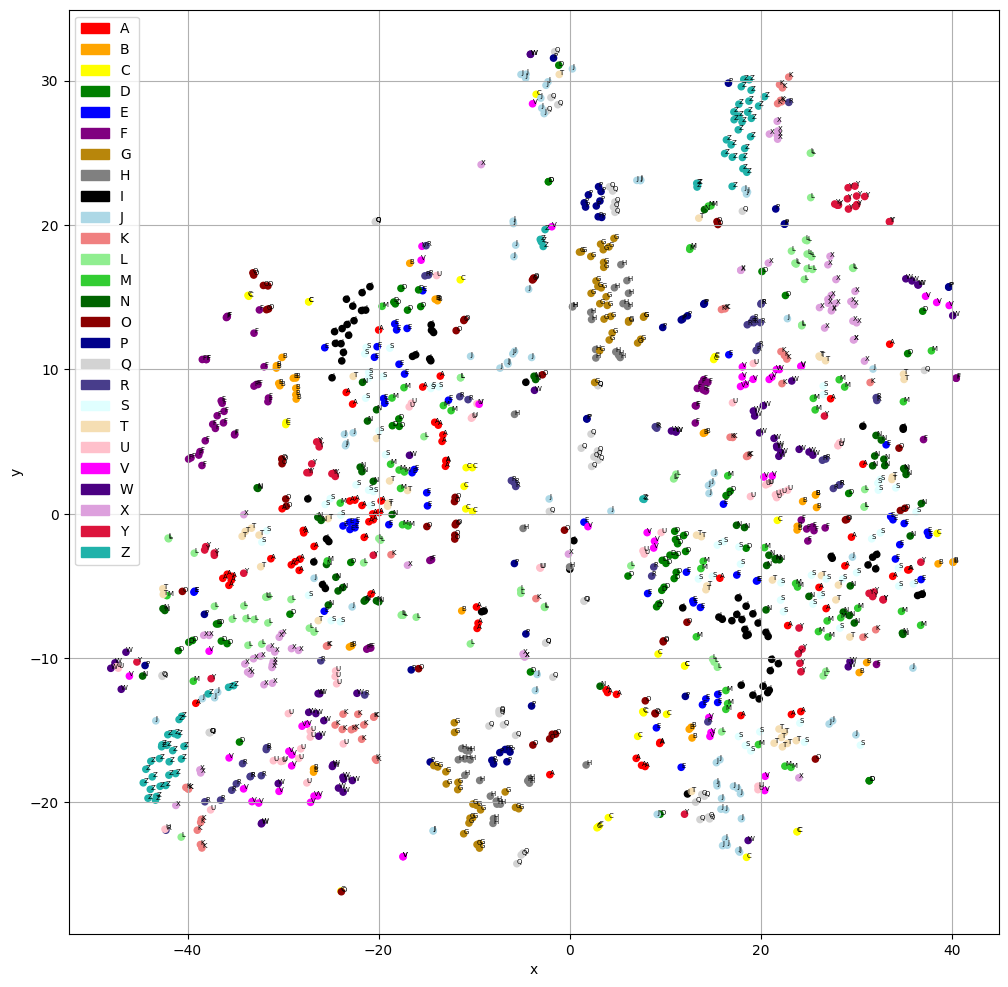

In [33]:
# t-sne plots for logical perplexities standard dataset:
for i in perplexities:
    plot_tsne(df_training_x, df_training_y, i)

[t-SNE] Computing 100 nearest neighbors...
[t-SNE] Indexed 1298 samples in 0.000s...
[t-SNE] Computed neighbors for 1298 samples in 0.027s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1298
[t-SNE] Computed conditional probabilities for sample 1298 / 1298
[t-SNE] Mean sigma: 0.506756
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.219826
[t-SNE] KL divergence after 1000 iterations: 0.581063


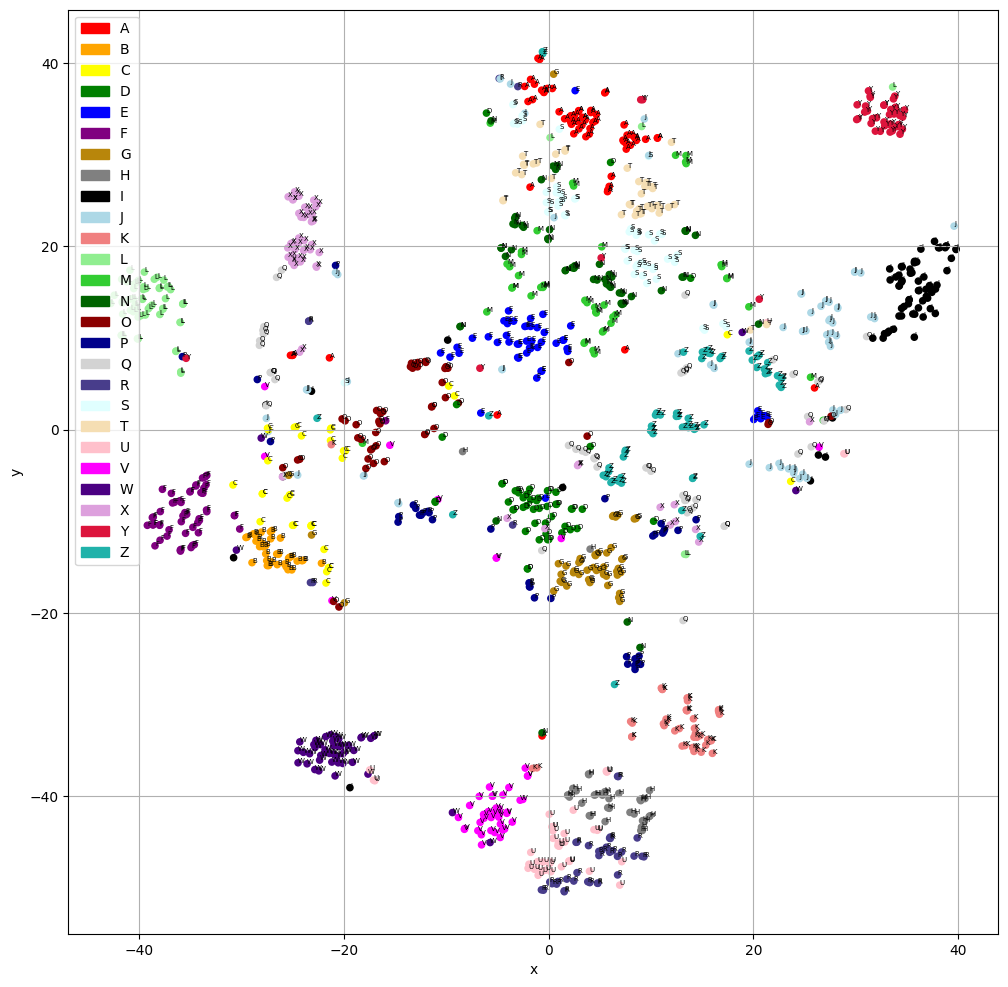

[t-SNE] Computing 125 nearest neighbors...
[t-SNE] Indexed 1298 samples in 0.001s...
[t-SNE] Computed neighbors for 1298 samples in 0.019s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1298
[t-SNE] Computed conditional probabilities for sample 1298 / 1298
[t-SNE] Mean sigma: 0.539888
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.248283
[t-SNE] KL divergence after 1000 iterations: 0.574223


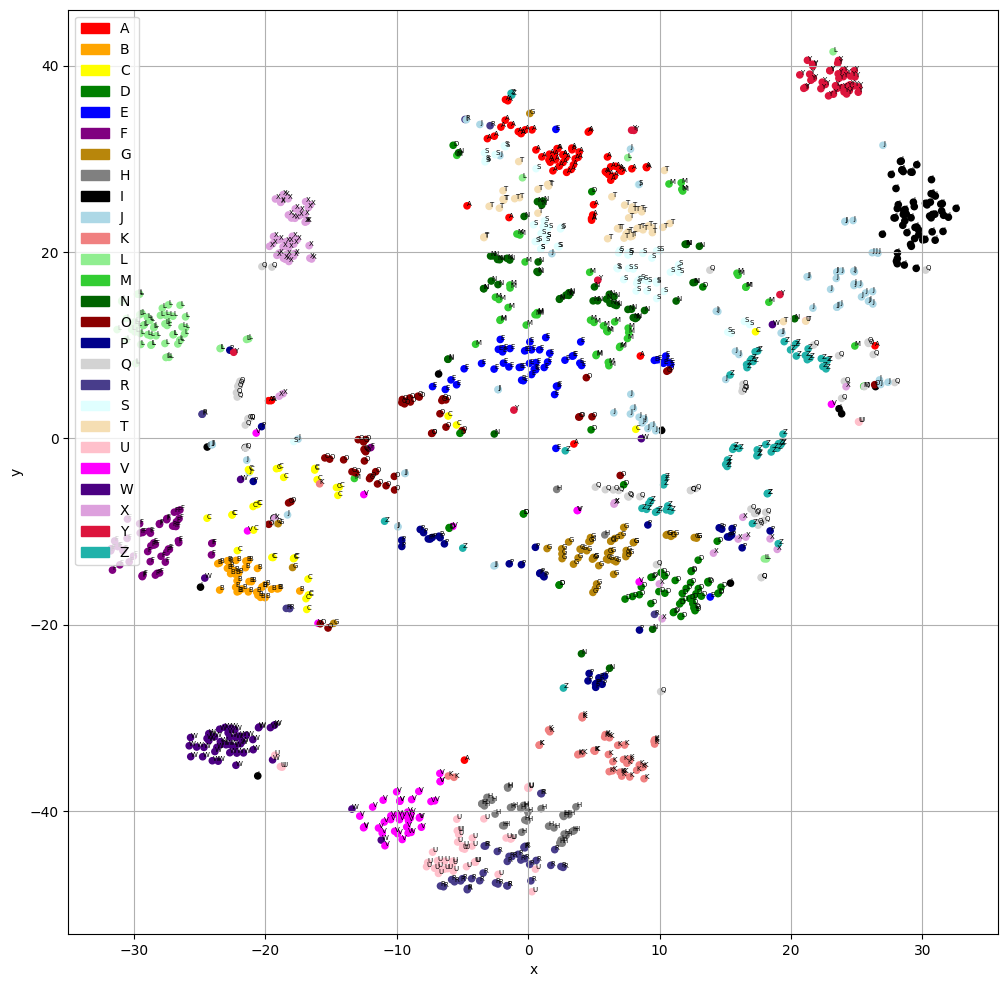

[t-SNE] Computing 150 nearest neighbors...
[t-SNE] Indexed 1298 samples in 0.000s...
[t-SNE] Computed neighbors for 1298 samples in 0.025s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1298
[t-SNE] Computed conditional probabilities for sample 1298 / 1298
[t-SNE] Mean sigma: 0.567917
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.995598
[t-SNE] KL divergence after 1000 iterations: 0.574366


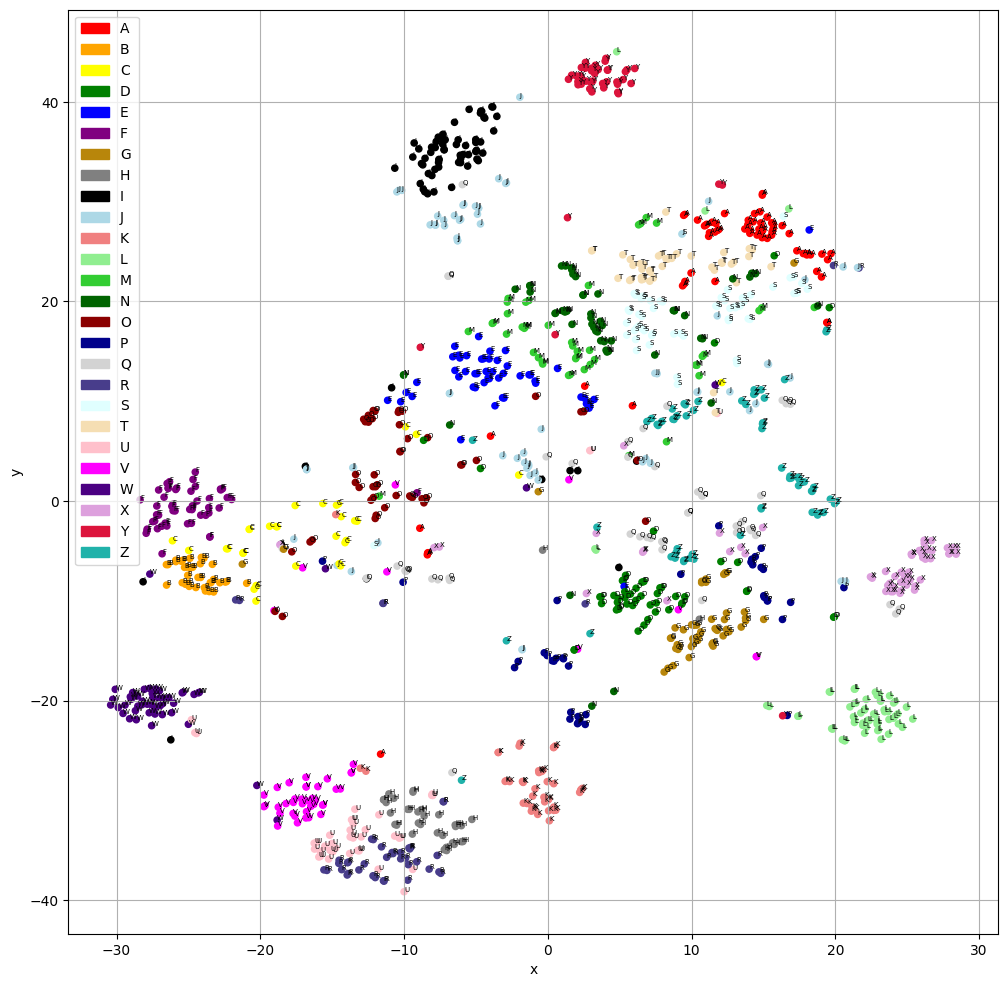

In [34]:
# t-sne plots for logical perplexities normalized dataset:
for i in perplexities:    
    plot_tsne(df_training_normalized_x, df_training_normalized_y, i)

[t-SNE] Computing 100 nearest neighbors...
[t-SNE] Indexed 1298 samples in 0.000s...
[t-SNE] Computed neighbors for 1298 samples in 0.019s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1298
[t-SNE] Computed conditional probabilities for sample 1298 / 1298
[t-SNE] Mean sigma: 0.523203
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.603367
[t-SNE] KL divergence after 1000 iterations: 0.580621


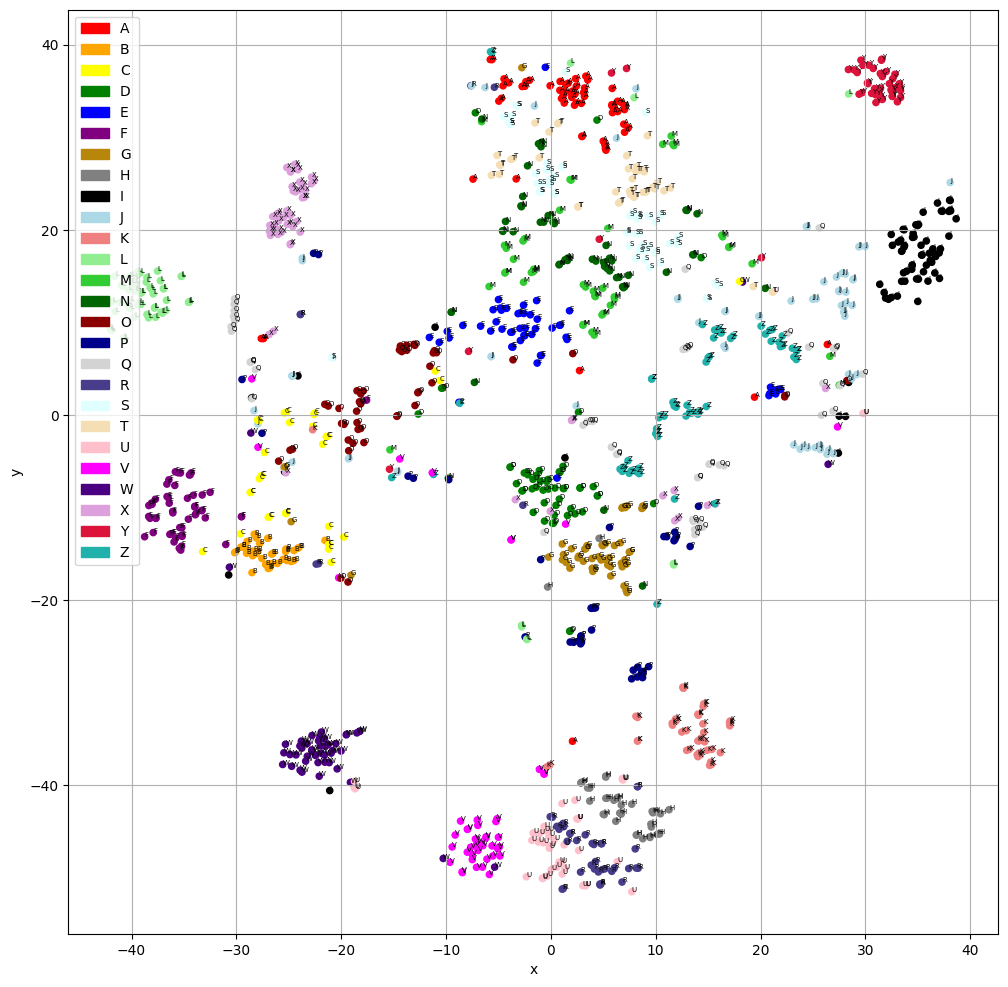

[t-SNE] Computing 125 nearest neighbors...
[t-SNE] Indexed 1298 samples in 0.000s...
[t-SNE] Computed neighbors for 1298 samples in 0.027s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1298
[t-SNE] Computed conditional probabilities for sample 1298 / 1298
[t-SNE] Mean sigma: 0.557439
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.329758
[t-SNE] KL divergence after 1000 iterations: 0.595841


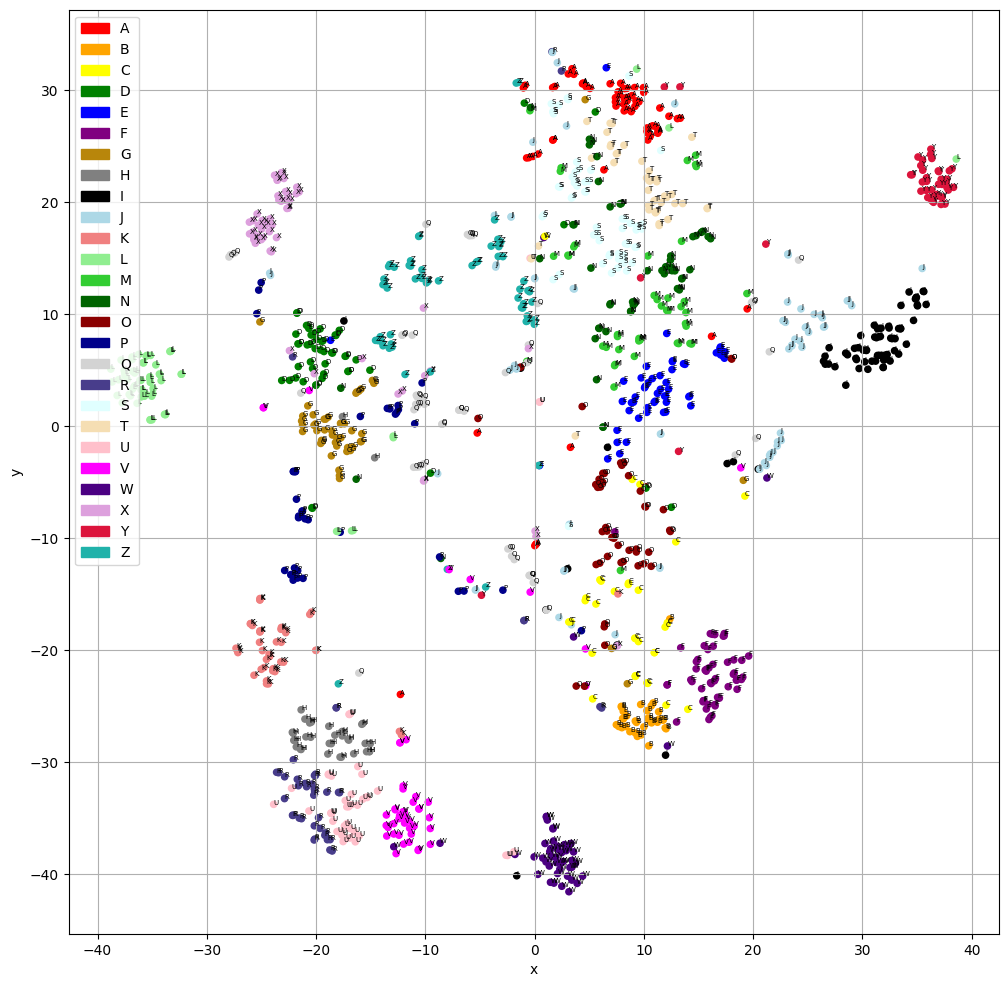

[t-SNE] Computing 150 nearest neighbors...
[t-SNE] Indexed 1298 samples in 0.000s...
[t-SNE] Computed neighbors for 1298 samples in 0.024s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1298
[t-SNE] Computed conditional probabilities for sample 1298 / 1298
[t-SNE] Mean sigma: 0.586350
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.222748
[t-SNE] KL divergence after 1000 iterations: 0.575235


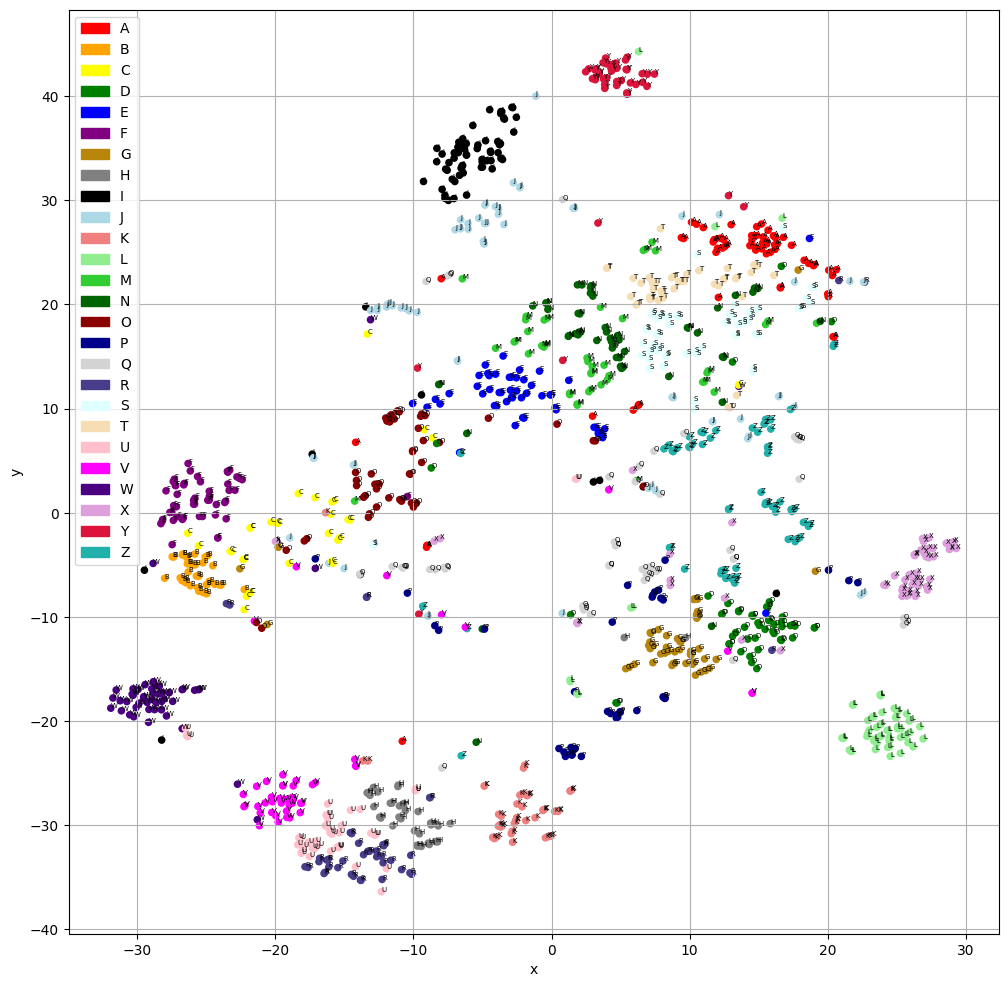

In [35]:
# t-sne plots for logical perplexities normalized dataset including tilt:
for i in perplexities:    
    plot_tsne(df_training_normalized_tilt_x, df_training_normalized_tilt_y, i)

[t-SNE] Computing 100 nearest neighbors...
[t-SNE] Indexed 1298 samples in 0.000s...
[t-SNE] Computed neighbors for 1298 samples in 0.027s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1298
[t-SNE] Computed conditional probabilities for sample 1298 / 1298
[t-SNE] Mean sigma: 0.484516
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.516685
[t-SNE] KL divergence after 1000 iterations: 0.540965


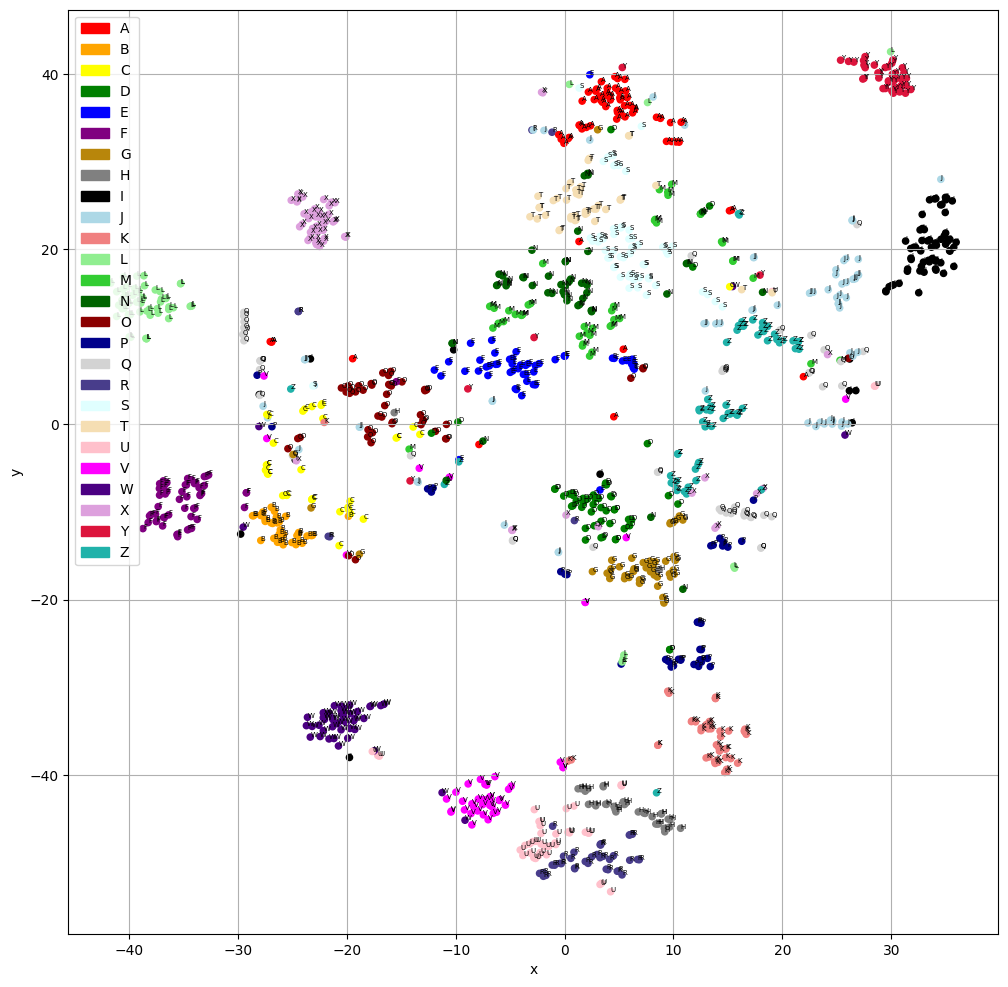

[t-SNE] Computing 125 nearest neighbors...
[t-SNE] Indexed 1298 samples in 0.000s...
[t-SNE] Computed neighbors for 1298 samples in 0.029s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1298
[t-SNE] Computed conditional probabilities for sample 1298 / 1298
[t-SNE] Mean sigma: 0.521308
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.662178
[t-SNE] KL divergence after 1000 iterations: 0.533522


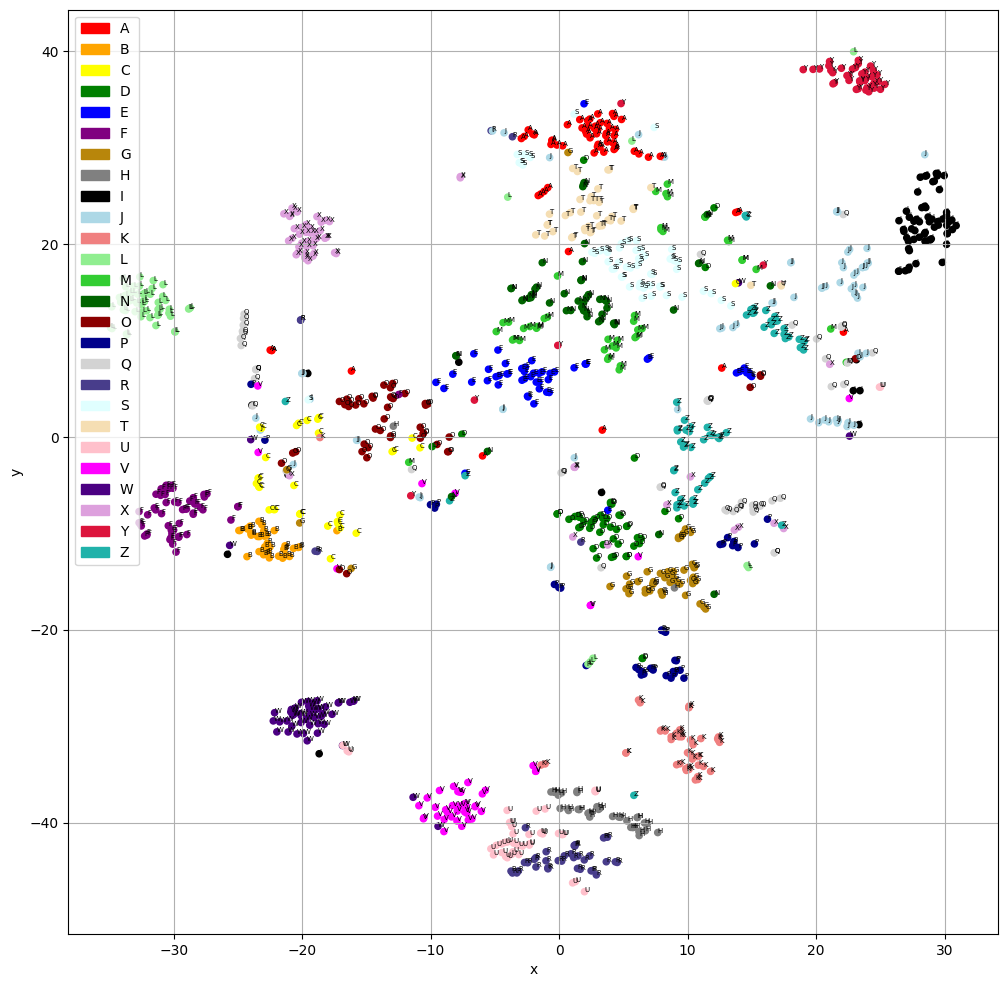

[t-SNE] Computing 150 nearest neighbors...
[t-SNE] Indexed 1298 samples in 0.000s...
[t-SNE] Computed neighbors for 1298 samples in 0.025s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1298
[t-SNE] Computed conditional probabilities for sample 1298 / 1298
[t-SNE] Mean sigma: 0.551867
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.772827
[t-SNE] KL divergence after 1000 iterations: 0.531190


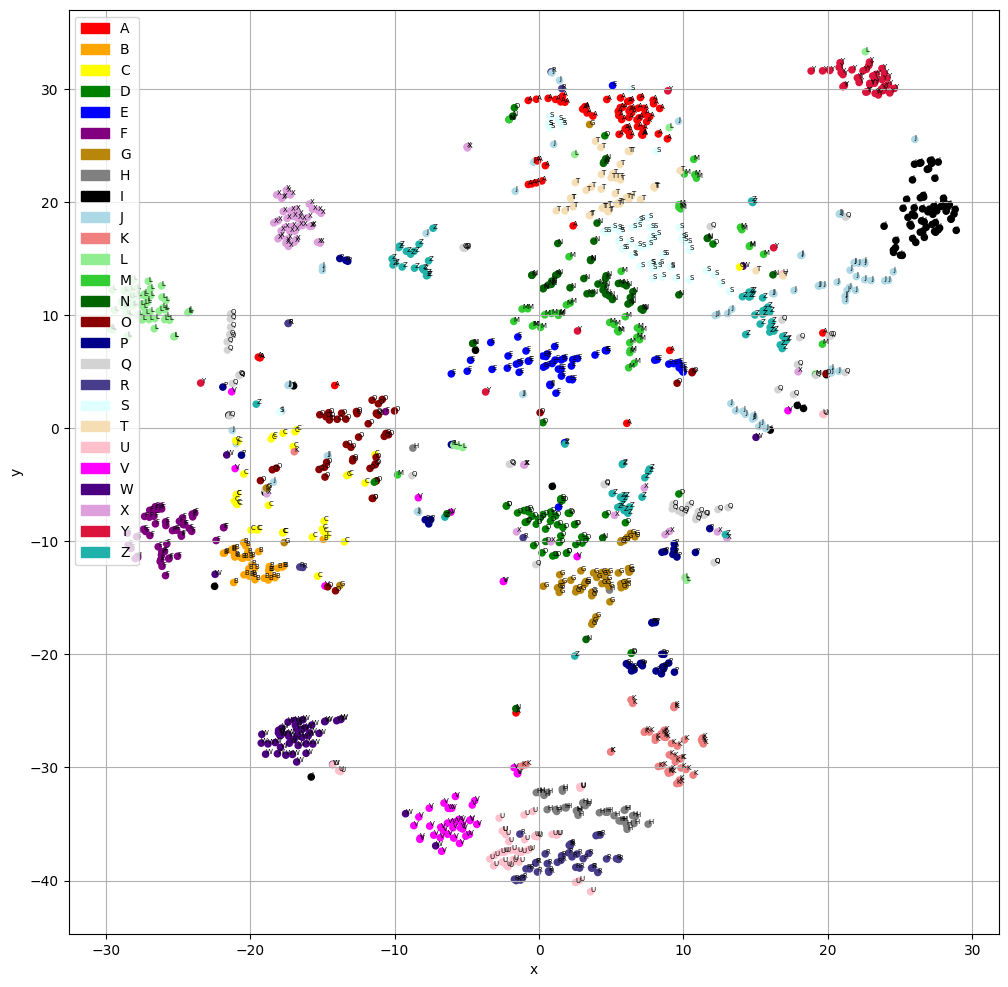

In [36]:
# t-sne plots for logical perplexities normalized dataset including tilt and mirror:
for i in perplexities:    
    plot_tsne(df_training_normalized_tilt_mirror_x, df_training_normalized_tilt_mirror_y, i)

## Train models

### Logistic Regression

In [37]:
# Logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

def train_logistic_regression(X_train, y_train):
    return LogisticRegression(max_iter=2000, tol=1e-12).fit(X_train.values, y_train.values)

def test_logistic_regression(model, title, X, y):
    print(f'Statistics: {title}')
    print('accuracy: {:5.4f}'.format(accuracy_score(y_true=y, y_pred=model.predict(X=X.values))))
    print('precision: {:5.4f}'.format(precision_score(y_true=y, y_pred=model.predict(X=X.values), average='micro')))
    print('recall: {:5.4f}'.format(recall_score(average='weighted', y_true=y, y_pred=model.predict(X=X.values))))
    print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=y, y_pred=model.predict(X=X.values))))    
    # print(classification_report(y_true=y, y_pred=model.predict(X=X.values)))
    

print('Raw results')
model = train_logistic_regression(df_training_x, df_training_y)
print('model fit in {} iterations'.format(model.n_iter_[0]))
test_logistic_regression(model, 'Training', df_training_x, df_training_y)
print()
test_logistic_regression(model, 'Validation', df_valid_x, df_valid_y)
print()
test_logistic_regression(model, 'Test', df_test_x, df_test_y)
print("---------------------------------------------")
print()
print('Normalized results')
model_normalized = train_logistic_regression(df_training_normalized_x, df_training_normalized_y)
print('model fit in {} iterations'.format(model.n_iter_[0]))
test_logistic_regression(model_normalized, 'Training', df_training_normalized_x, df_training_normalized_y)
print()
test_logistic_regression(model_normalized, 'Validation', df_valid_normalized_x, df_valid_normalized_y)
print()
test_logistic_regression(model_normalized, 'Test', df_test_normalized_x, df_test_normalized_y)
print("---------------------------------------------")
print()
print('Normalized including tilt results')
model_normalized_tilt = train_logistic_regression(df_training_normalized_tilt_x, df_training_normalized_tilt_y)
print('model fit in {} iterations'.format(model.n_iter_[0]))
test_logistic_regression(model_normalized_tilt, 'Training', df_training_normalized_tilt_x, df_training_normalized_tilt_y)
print()
test_logistic_regression(model_normalized_tilt, 'Validation', df_valid_normalized_tilt_x, df_valid_normalized_tilt_y)
print()
test_logistic_regression(model_normalized_tilt, 'Test', df_test_normalized_tilt_x, df_test_normalized_tilt_y)
print("---------------------------------------------")
print()
print('Normalized including tilt and mirror results')
model_normalized_tilt_mirror = train_logistic_regression(df_training_normalized_tilt_mirror_x, df_training_normalized_tilt_mirror_y)
print('model fit in {} iterations'.format(model.n_iter_[0]))
test_logistic_regression(model_normalized_tilt_mirror, 'Training', df_training_normalized_tilt_mirror_x, df_training_normalized_tilt_mirror_y)
print()
test_logistic_regression(model_normalized_tilt_mirror, 'Validation', df_valid_normalized_tilt_mirror_x, df_valid_normalized_tilt_mirror_y)
print()
test_logistic_regression(model_normalized_tilt_mirror, 'Test', df_test_normalized_tilt_mirror_x, df_test_normalized_tilt_mirror_y)

Raw results
model fit in 296 iterations
Statistics: Training
accuracy: 0.6649
precision: 0.6649
recall: 0.6649
f1: 0.6565

Statistics: Validation
accuracy: 0.5662
precision: 0.5662
recall: 0.5662
f1: 0.5489

Statistics: Test
accuracy: 0.5606
precision: 0.5606
recall: 0.5606
f1: 0.5362
---------------------------------------------

Normalized results


/opt/anaconda3/envs/mp312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


model fit in 296 iterations
Statistics: Training
accuracy: 0.8544
precision: 0.8544
recall: 0.8544
f1: 0.8531

Statistics: Validation
accuracy: 0.7941
precision: 0.7941
recall: 0.7941
f1: 0.7980

Statistics: Test
accuracy: 0.8485
precision: 0.8485
recall: 0.8485
f1: 0.8317
---------------------------------------------

Normalized including tilt results
model fit in 296 iterations
Statistics: Training
accuracy: 0.8652
precision: 0.8652
recall: 0.8652
f1: 0.8647

Statistics: Validation
accuracy: 0.8015
precision: 0.8015
recall: 0.8015
f1: 0.8056

Statistics: Test
accuracy: 0.8485
precision: 0.8485
recall: 0.8485
f1: 0.8421
---------------------------------------------

Normalized including tilt and mirror results
model fit in 296 iterations
Statistics: Training
accuracy: 0.8652
precision: 0.8652
recall: 0.8652
f1: 0.8646

Statistics: Validation
accuracy: 0.8088
precision: 0.8088
recall: 0.8088
f1: 0.8111

Statistics: Test
accuracy: 0.8333
precision: 0.8333
recall: 0.8333
f1: 0.8245


### Random Forest

In [38]:
# test random forest model
from sklearn.ensemble import RandomForestClassifier

# TODO hypertune parameters...
def train_rf_model(X_train, y_train):
    hyperparameters = {
        'n_jobs': -1,
        'criterion': 'log_loss', # {'gini', 'log_loss', 'entropy'}
        'max_depth': 20, # max 26 letters?
        'max_features': 'sqrt', # {'sqrt', 'log2', None }
        'n_estimators': 100, # 10 - 100 (standard=100)
        'random_state': 42,
        'min_samples_leaf': 10, # experiment with values 10 - 50?
        'min_samples_split': 15 # experiment with values 5-20?
        # max_leaf_nodes
        # min_impurity_decrease
        # min_weight_fraction_leaf
    }
    model = RandomForestClassifier(**hyperparameters)
    model.fit(X_train, y_train)
    return model

def test_rf_model(model, title, X, y):
    # y_pred = model.predict_proba(X_test)[:,1]
    print(f'Statistics: {title}')
    print('accuracy: {:5.4f}'.format(accuracy_score(y_true=y, y_pred=model.predict(X=X))))
    print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=y, y_pred=model.predict(X=X))))
    # print(classification_report(y_true=y, y_pred=model.predict(X=X)))
    

print('Raw data')
rf_model = train_rf_model(df_training_x, df_training_y)
test_rf_model(rf_model, 'Training', df_training_x, df_training_y)
print()
test_rf_model(rf_model, 'Validation', df_valid_x, df_valid_y)
print()
test_rf_model(rf_model, 'Test', df_test_x, df_test_y)
print("---------------------------------------------")
print()

print('Normalized data')
rf_model_normalized = train_rf_model(df_training_normalized_x, df_training_normalized_y)
test_rf_model(rf_model_normalized, 'Training', df_training_normalized_x, df_training_normalized_y)
print()
test_rf_model(rf_model_normalized, 'Validation', df_valid_normalized_x, df_valid_normalized_y)
print()
test_rf_model(rf_model_normalized, 'Test', df_test_normalized_x, df_test_normalized_y)
print("---------------------------------------------")
print()

print('Normalized including tilt data')
rf_model_normalized_tilt = train_rf_model(df_training_normalized_tilt_x, df_training_normalized_tilt_y)
test_rf_model(rf_model_normalized_tilt, 'Training', df_training_normalized_tilt_x, df_training_normalized_tilt_y)
print()
test_rf_model(rf_model_normalized_tilt, 'Validation', df_valid_normalized_tilt_x, df_valid_normalized_tilt_y)
print()
test_rf_model(rf_model_normalized_tilt, 'Test', df_test_normalized_tilt_x, df_test_normalized_tilt_y)
print("---------------------------------------------")
print()

print('Normalized including tilt and mirror data')
rf_model_normalized_tilt_mirror = train_rf_model(df_training_normalized_tilt_mirror_x, df_training_normalized_tilt_mirror_y)
test_rf_model(rf_model_normalized_tilt_mirror, 'Training', df_training_normalized_tilt_mirror_x, df_training_normalized_tilt_mirror_y)
print()
test_rf_model(rf_model_normalized_tilt_mirror, 'Validation', df_valid_normalized_tilt_mirror_x, df_valid_normalized_tilt_mirror_y)
print()
test_rf_model(rf_model_normalized_tilt_mirror, 'Test', df_test_normalized_tilt_mirror_x, df_test_normalized_tilt_mirror_y)

Raw data
Statistics: Training
accuracy: 0.8837
f1: 0.8825

Statistics: Validation
accuracy: 0.5809
f1: 0.5558

Statistics: Test
accuracy: 0.6667
f1: 0.6544
---------------------------------------------

Normalized data
Statistics: Training
accuracy: 0.8937
f1: 0.8949

Statistics: Validation
accuracy: 0.8088
f1: 0.8136

Statistics: Test
accuracy: 0.7879
f1: 0.7789
---------------------------------------------

Normalized including tilt data
Statistics: Training
accuracy: 0.8945
f1: 0.8963

Statistics: Validation
accuracy: 0.8088
f1: 0.8086

Statistics: Test
accuracy: 0.8030
f1: 0.8014
---------------------------------------------

Normalized including tilt and mirror data
Statistics: Training
accuracy: 0.9122
f1: 0.9130

Statistics: Validation
accuracy: 0.8235
f1: 0.8239

Statistics: Test
accuracy: 0.7576
f1: 0.7566


### Neural network

In [39]:
from sklearn.neural_network import MLPClassifier

def train_nn_model(X_train, y_train):
    clf = MLPClassifier(
        solver='adam', 
        alpha=1e-5,
        hidden_layer_sizes=(26, 26), 
        random_state=42,
        max_iter=2000
    )
    clf.fit(X_train, y_train)
    return clf

def test_nn_model(model, title, X, y):
    print(f'Statistics: {title}')
    print('accuracy: {:5.4f}'.format(accuracy_score(y_true=y, y_pred=model.predict(X=X))))
    print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=y, y_pred=model.predict(X=X))))
    # print(classification_report(y_true=y, y_pred=model.predict(X=X)))

print("Standard data:")
nn_model = train_nn_model(df_training_x, df_training_y)
test_nn_model(nn_model, 'Training', df_training_x, df_training_y)
print()
test_nn_model(nn_model, 'Validation', df_valid_x, df_valid_y)
print()
test_nn_model(nn_model, 'Test', df_test_x, df_test_y)
print("---------------------------------------------")
print()

print("Normalized data:")
nn_model_normalized = train_nn_model(df_training_normalized_x, df_training_normalized_y)
test_nn_model(nn_model_normalized, 'Training', df_training_normalized_x, df_training_normalized_y)
print()
test_nn_model(nn_model_normalized, 'Validation', df_valid_normalized_x, df_valid_normalized_y)
print()
test_nn_model(nn_model_normalized, 'Test', df_test_normalized_x, df_test_normalized_y)
print("---------------------------------------------")
print()

print("Normalized including tilt data:")
nn_model_normalized_tilt = train_nn_model(df_training_normalized_tilt_x, df_training_normalized_tilt_y)
test_nn_model(nn_model_normalized_tilt, 'Training', df_training_normalized_tilt_x, df_training_normalized_tilt_y)
print()
test_nn_model(nn_model_normalized_tilt, 'Validation', df_valid_normalized_tilt_x, df_valid_normalized_tilt_y)
print()
test_nn_model(nn_model_normalized_tilt, 'Test', df_test_normalized_tilt_x, df_test_normalized_tilt_y)

print("---------------------------------------------")
print()

print("Normalized including tilt and mirror data:")
nn_model_normalized_tilt_mirror = train_nn_model(df_training_normalized_tilt_mirror_x, df_training_normalized_tilt_mirror_y)
test_nn_model(nn_model_normalized_tilt_mirror, 'Training', df_training_normalized_tilt_mirror_x, df_training_normalized_tilt_mirror_y)
print()
test_nn_model(nn_model_normalized_tilt_mirror, 'Validation', df_valid_normalized_tilt_mirror_x, df_valid_normalized_tilt_mirror_y)
print()
test_nn_model(nn_model_normalized_tilt_mirror, 'Test', df_test_normalized_tilt_mirror_x, df_test_normalized_tilt_mirror_y)


Standard data:
Statistics: Training
accuracy: 0.8713
f1: 0.8711

Statistics: Validation
accuracy: 0.6912
f1: 0.6978

Statistics: Test
accuracy: 0.6667
f1: 0.6792
---------------------------------------------

Normalized data:
Statistics: Training
accuracy: 0.9961
f1: 0.9962

Statistics: Validation
accuracy: 0.7794
f1: 0.7785

Statistics: Test
accuracy: 0.8030
f1: 0.8089
---------------------------------------------

Normalized including tilt data:
Statistics: Training
accuracy: 0.9854
f1: 0.9854

Statistics: Validation
accuracy: 0.8309
f1: 0.8341

Statistics: Test
accuracy: 0.8182
f1: 0.8079
---------------------------------------------

Normalized including tilt and mirror data:
Statistics: Training
accuracy: 0.9838
f1: 0.9839

Statistics: Validation
accuracy: 0.8456
f1: 0.8453

Statistics: Test
accuracy: 0.7879
f1: 0.7734


### SVM

In [40]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

X_raw = df_training_x.values  # raw landmark-features
y_raw = df_training_y.values

X_norm = df_training_normalized_x.values  # genormaliseerde landmark-features
y_norm = df_training_normalized_y.values

X_norm_tilt = df_training_normalized_tilt_x.values  # genormaliseerde landmark-features including tilt
y_norm_tilt = df_training_normalized_tilt_y.values

X_norm_tilt_mirror = df_training_normalized_tilt_mirror_x.values  # genormaliseerde landmark-features including tilt and mirror
y_norm_tilt_mirror = df_training_normalized_tilt_mirror_y.values

def train_svc_model(X, y):
    pipe = make_pipeline(
        StandardScaler(),
        SVC(kernel="rbf", class_weight="balanced")
    )
    
    param_dist = {
        "svc__C":     np.logspace(-2, 3, 20),              # 0.01 ... 100
        "svc__gamma": ["scale"] + list(np.logspace(-4, -1, 10))  # 'scale' + 1e-4..1e-1
    }
    
    # Nested CV: eerlijke performance (inner: tuning, outer: testen)
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    oof_pred = np.empty_like(y, dtype=y.dtype)
    accs, f1s = [], []
    cm_total = None
    labels_all = np.unique(y)
    best_params_per_fold = []
    
    for fold, (tr, te) in enumerate(outer_cv.split(X, y), 1):
        Xtr, ytr = X[tr], y[tr]
        Xte, yte = X[te], y[te]
    
        search = RandomizedSearchCV(
            estimator=pipe,
            param_distributions=param_dist,
            n_iter=20,
            cv=inner_cv,
            scoring="f1_weighted",
            n_jobs=-1,
            refit=True,
            random_state=42
        )
        search.fit(Xtr, ytr)
        best_clf = search.best_estimator_
        best_params_per_fold.append((search.best_params_, search.best_score_))
    
        yhat = best_clf.predict(Xte)
        oof_pred[te] = yhat
    
        acc = accuracy_score(yte, yhat)
        f1w = f1_score(yte, yhat, average="weighted")
        accs.append(acc); f1s.append(f1w)
    
        print(f"[Fold {fold}] acc={acc:.3f}, f1_w={f1w:.3f}, best={search.best_params_}")
    
        cm = confusion_matrix(yte, yhat, labels=labels_all)
        cm_total = cm if cm_total is None else cm_total + cm
    
    print("\n Nested-CV samenvatting (zonder LOF)")
    print("Accuracy: {:.3f} ± {:.3f}".format(np.mean(accs), np.std(accs)))
    print("F1_wght: {:.3f} ± {:.3f}".format(np.mean(f1s), np.std(f1s)))
    
    print("\n Classification report (OOF)")
    print(classification_report(y_true=y, y_pred=oof_pred, zero_division=0))
    
    cm_df = pd.DataFrame(cm_total, index=labels_all, columns=labels_all)
    print("\n Confusion matrix (OOF, som over folds)")
    print(cm_df)
    
    # Eindmodel (beste params op volledige data)
    final_search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_dist,
        n_iter=50,
        cv=outer_cv,
        scoring="f1_weighted",
        n_jobs=-1,
        refit=True,
        random_state=123
    )
    final_search.fit(X, y)
    print("\n Beste SVC op volledige data")
    print("Best params:", final_search.best_params_)
    print("CV f1_weighted (mean): {:.3f}".format(final_search.best_score_))
    
    final_model = final_search.best_estimator_  # <- gebruik dit om later op nieuwe beelden te voorspellen
    return final_model

svc_model_raw = train_svc_model(X_raw, y_raw)
svc_model_norm = train_svc_model(X_norm, y_norm)
svc_model_norm_tilt = train_svc_model(X_norm_tilt, y_norm_tilt)
svc_model_norm_tilt_mirror = train_svc_model(X_norm_tilt_mirror, y_norm_tilt_mirror)

[Fold 1] acc=0.854, f1_w=0.852, best={'svc__gamma': 0.001, 'svc__C': 162.3776739188721}
[Fold 2] acc=0.881, f1_w=0.879, best={'svc__gamma': 0.001, 'svc__C': 162.3776739188721}
[Fold 3] acc=0.869, f1_w=0.867, best={'svc__gamma': 0.001, 'svc__C': 162.3776739188721}
[Fold 4] acc=0.896, f1_w=0.895, best={'svc__gamma': 0.01, 'svc__C': 88.58667904100822}
[Fold 5] acc=0.876, f1_w=0.875, best={'svc__gamma': 0.001, 'svc__C': 162.3776739188721}

 Nested-CV samenvatting (zonder LOF)
Accuracy: 0.875 ± 0.014
F1_wght: 0.874 ± 0.014

 Classification report (OOF)
              precision    recall  f1-score   support

           A       0.83      0.94      0.88        64
           B       0.92      0.97      0.94        35
           C       0.91      0.91      0.91        33
           D       0.83      0.78      0.80        50
           E       0.89      0.94      0.91        51
           F       0.98      0.96      0.97        53
           G       0.88      1.00      0.93        49
           H 

In [30]:
# test on validation and test data
def test_svc_model(model, title, X, y):
    print(f'Statistics: {title}')
    print('accuracy: {:5.4f}'.format(accuracy_score(y_true=y, y_pred=model.predict(X=X))))
    print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=y, y_pred=model.predict(X=X))))
    # print(classification_report(y_true=y, y_pred=model.predict(X=X)))
    print()
    
print("Standard data:")  
test_svc_model(svc_model_raw, 'Validation', df_valid_x.values, df_valid_y)
print()
test_svc_model(svc_model_raw, 'Test', df_test_x.values, df_test_y)
print("-----------------------------------------")
print()

print("Normalized data:")
test_svc_model(svc_model_norm, 'Validation', df_valid_normalized_x.values, df_valid_normalized_y)
print()
test_svc_model(svc_model_norm, 'Test', df_test_normalized_x.values, df_test_normalized_y)
print("-----------------------------------------")
print()

print("Normalized including tilt data:")
test_svc_model(svc_model_norm_tilt, 'Validation', df_valid_normalized_tilt_x.values, df_valid_normalized_tilt_y)
print()
test_svc_model(svc_model_norm_tilt, 'Test', df_test_normalized_tilt_x.values, df_test_normalized_tilt_y)

Standard data:
Statistics: Validation
accuracy: 0.7868
f1: 0.7896


Statistics: Test
accuracy: 0.7424
f1: 0.7389

-----------------------------------------

Normalized data:
Statistics: Validation
accuracy: 0.8456
f1: 0.8452


Statistics: Test
accuracy: 0.8636
f1: 0.8623

-----------------------------------------

Normalized including tilt data:
Statistics: Validation
accuracy: 0.8015
f1: 0.8050


Statistics: Test
accuracy: 0.8636
f1: 0.8580



## Outlier experiment

In [41]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict

X = df_training_x.values
y = df_training_y.values

# Per-klasse outlier detectie (LOF) met veilige fallback
mask = np.ones(len(X), dtype=bool)

contamination = 0.10
base_neighbors = 20

for c in np.unique(y):
    idx = np.where(y == c)[0]
    Xc = X[idx]
    n_samples_c = len(Xc)

    # te weinig samples => geen LOF (alles inlier laten)
    if n_samples_c < 4:
        continue

    # kies geldige n_neighbors voor deze klasse
    n_neighbors = min(base_neighbors, n_samples_c - 1)
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    pred = lof.fit_predict(Xc)  # -1 outlier, 1 inlier
    mask[idx] = (pred == 1)

"""
    LOF selecteert de outliers en inliers per klasse o.b.v. een contamination en herkent daarmee 'afwijkend' gedrag.
    Het gevolg hiervan is dat je de dataset kun 'zuiveren' om een verbeterde accuracy te behalen. (wat in sommige gevallen wenselijk is)
    
    Echter, door outliers te detecteren en te verwijderen uit de dataset verlies je ook een bepaalde variatie uit het model in het geval dat het wel een legitiem voorbeeld is.
    Ondanks dat het trainen een verbeterde accuracy geeft zorgt minder variatie dus ook voor minder bergip in het model. (niet wenselijk voor nieuwe cases)
    
    Ik denk daarmee dus dat we het gebruik van outlier detectie/cleaning niet blind moeten gebruiken maar vooral ook moeten inzetten als hulpmiddel.
    Het is wel wenselijk om te voorkomen dat er corrupte beelden of extreme afwijkingen te cleanen, maar het is niet wenselijk om outliers die wél realistische variatie vertonen te cleanen.
"""

X_clean, y_clean = X[mask], y[mask]
print(f"Verwijderd: {np.sum(~mask)} samples ({100*np.mean(~mask):.1f}%).")

def make_cv_for_labels(labels, max_splits=5):
    _, counts = np.unique(labels, return_counts=True)
    min_count = counts.min()
    # we willen minstens 2 folds, maar niet meer dan min_count
    n_splits = max(2, min(max_splits, min_count))
    return StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42), n_splits


# Objectieve vergelijking met CV
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000))

# CV voor raw data
cv_raw, n_raw = make_cv_for_labels(y, max_splits=5)
scores_raw = cross_validate(pipe, X, y, cv=cv_raw, scoring=["accuracy","f1_weighted"])
y_pred_raw_cv = cross_val_predict(pipe, X, y, cv=cv_raw)

# CV voor clean data
cv_clean, n_clean = make_cv_for_labels(y_clean, max_splits=5)
scores_clean = cross_validate(pipe, X_clean, y_clean, cv=cv_clean, scoring=["accuracy","f1_weighted"])
y_pred_clean_cv = cross_val_predict(pipe, X_clean, y_clean, cv=cv_clean)

# ---------- prints ----------
print(f"\nZonder filter (cv folds = {n_raw}) — acc: {scores_raw['test_accuracy'].mean():.3f} ± {scores_raw['test_accuracy'].std():.3f}, "
      f"f1: {scores_raw['test_f1_weighted'].mean():.3f} ± {scores_raw['test_f1_weighted'].std():.3f}")
print("Classification report (Zonder filter):")
print(classification_report(y_true=y, y_pred=y_pred_raw_cv, zero_division=0))

print(f"\nMet LOF-filter (cv folds = {n_clean}) — acc: {scores_clean['test_accuracy'].mean():.3f} ± {scores_clean['test_accuracy'].std():.3f}, "
      f"f1: {scores_clean['test_f1_weighted'].mean():.3f} ± {scores_clean['test_f1_weighted'].std():.3f}")
print("Classification report (Met LOF-filter):")
print(classification_report(y_true=y_clean, y_pred=y_pred_clean_cv, zero_division=0))

Verwijderd: 139 samples (10.7%).

Zonder filter (cv folds = 5) — acc: 0.831 ± 0.017, f1: 0.828 ± 0.020
Classification report (Zonder filter):
              precision    recall  f1-score   support

           A       0.80      0.92      0.86        64
           B       0.85      1.00      0.92        35
           C       0.85      0.70      0.77        33
           D       0.75      0.76      0.75        50
           E       0.98      0.86      0.92        51
           F       0.98      0.96      0.97        53
           G       0.87      0.96      0.91        49
           H       0.94      0.92      0.93        36
           I       0.84      0.87      0.86        71
           J       0.61      0.72      0.66        71
           K       0.84      0.96      0.90        45
           L       0.88      0.88      0.88        64
           M       0.78      0.89      0.83        45
           N       0.89      0.79      0.84        53
           O       0.78      0.74      0.76    